# EXPLORATION 11. 작사가 인공지능 만들기

---

## Import

In [1]:
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

## utils

In [2]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

In [3]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  

    print(tensor,tokenizer)
    return tensor, tokenizer

In [4]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

In [5]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
        tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

## Dataset

In [6]:
txt_file_path = os.getenv('HOME')+'/aiffel//lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Hey, Vietnam, Vietnam, Vietnam, Vietnam', 'Vietnam, Vietnam, Vietnam Yesterday I got a letter from my friend', 'Fighting in Vietnam']


## Data Preprocessing

In [7]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> hey , vietnam , vietnam , vietnam , vietnam <end>',
 '<start> vietnam , vietnam , vietnam yesterday i got a letter from my friend <end>',
 '<start> fighting in vietnam <end>',
 '<start> and this is what he had to say <end>',
 '<start> tell all my friends that i ll be coming home soon <end>',
 '<start> my time it ll be up some time in june <end>',
 '<start> don t forget , he said to tell my sweet mary <end>',
 '<start> her golden lips as sweet as cherries and it came from <end>',
 '<start> vietnam , vietnam , vietnam , vietnam <end>',
 '<start> vietnam , vietnam , vietnam it was just the next day his mother got a telegram <end>']

In [8]:
tensor, tokenizer = tokenize(corpus)

[[   2  135    4 ...    0    0    0]
 [   2 1350    4 ...   13  308    3]
 [   2 1043   14 ...    0    0    0]
 ...
 [   2    5   61 ...    0    0    0]
 [   2  113  682 ...    0    0    0]
 [   2    8   50 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f1714f8fa10>


In [9]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <START>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2  135    4 1350    4 1350    4 1350    4 1350    3    0    0    0]
[ 135    4 1350    4 1350    4 1350    4 1350    3    0    0    0    0]


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=2020)

In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [13]:
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## Model

In [14]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.drop1 = tf.keras.layers.Dropout(0.3)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.drop1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 2048
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [15]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[ 1.3450939e-04,  1.9431842e-04,  6.5826345e-04, ...,
          6.7252561e-04, -2.5257989e-04,  1.0152693e-03],
        [-1.6151645e-04,  8.5445371e-04,  6.3464144e-04, ...,
          1.1881832e-03, -2.7399493e-04,  1.5679382e-03],
        [-3.9252752e-04,  6.3220767e-04,  8.5498398e-04, ...,
          1.4483191e-03, -9.3175890e-04,  1.8981083e-03],
        ...,
        [ 3.9022549e-03,  1.5955748e-03,  1.8970459e-04, ...,
          3.5897671e-04, -9.2148337e-05,  1.9062869e-03],
        [ 4.0667811e-03,  1.3115890e-03, -2.7780482e-04, ...,
          1.0592234e-04,  2.5221612e-04,  1.7512824e-03],
        [ 3.4290787e-03,  7.4810215e-04, -7.5264013e-04, ...,
         -5.5265392e-04,  1.1828416e-03,  2.2386902e-03]],

       [[ 1.3450939e-04,  1.9431842e-04,  6.5826345e-04, ...,
          6.7252561e-04, -2.5257989e-04,  1.0152693e-03],
        [-6.8696530e-04, -7.1341189e-04,  1.0045312e-03, ...,
          1.7465261e-03, -

In [16]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  14338048  
_________________________________________________________________
lstm (LSTM)                  multiple                  33562624  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  14345049  
Total params: 95,808,345
Trainable params: 95,808,345
Non-trainable params: 0
________________________________________

## Train

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [18]:
history = model.fit(dataset,
          epochs=7,
          validation_data=val_dataset,
          verbose=1)

Epoch 1/7
549/549 [==============================] - 288s 525ms/step - loss: 3.2488 - accuracy: 0.4806 - val_loss: 2.8874 - val_accuracy: 0.5103
Epoch 2/7
549/549 [==============================] - 289s 527ms/step - loss: 2.7417 - accuracy: 0.5219 - val_loss: 2.6394 - val_accuracy: 0.5355
Epoch 3/7
549/549 [==============================] - 289s 526ms/step - loss: 2.4669 - accuracy: 0.5491 - val_loss: 2.4792 - val_accuracy: 0.5569
Epoch 4/7
549/549 [==============================] - 289s 527ms/step - loss: 2.2227 - accuracy: 0.5777 - val_loss: 2.3597 - val_accuracy: 0.5769
Epoch 5/7
549/549 [==============================] - 289s 527ms/step - loss: 2.0015 - accuracy: 0.6075 - val_loss: 2.2731 - val_accuracy: 0.5948
Epoch 6/7
549/549 [==============================] - 290s 528ms/step - loss: 1.8090 - accuracy: 0.6369 - val_loss: 2.2132 - val_accuracy: 0.6091
Epoch 7/7
549/549 [==============================] - 290s 528ms/step - loss: 1.6495 - accuracy: 0.6638 - val_loss: 2.1772 - val_ac

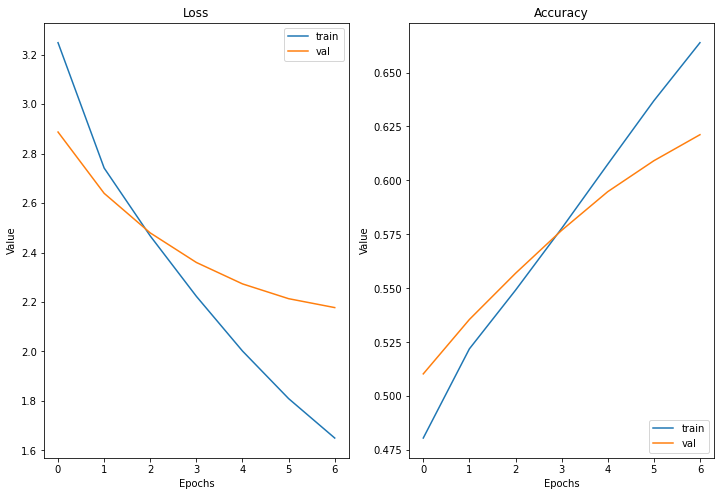

In [19]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

## Generate lyrics

In [20]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , liberian girl <end> '

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i am", max_len=20)

'<start> i am not throwing away my shot <end> '

## Report

Model  
LSTM layer 사이에 Dropout(0.3)을 적용하였습니다.  
embedding_size, hidden_size를 각각 다음과 같이 설정하였습니다.  
embedding_size = 2048, hidden_size = 2048  

<br>

최종적으로 val_loss를 2.1772을 얻었습니다.  
